## Loading dataset and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv(r"C:\Users\LENOVO PC\Downloads\flight_project\Flight_dataset.csv")
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [2]:
# For interpretability
import shap

RND = 42
np.random.seed(RND)
sns.set(style="whitegrid")

c:\Users\LENOVO PC\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df.shape

(300153, 11)

In [4]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [5]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [4]:
# Drop flight column
df = df.drop(columns=["flight"])

In [5]:
# Map stops
df["stops"] = df["stops"].map({"zero": 0, "one": 1, "two_or_more": 2})

## EDA

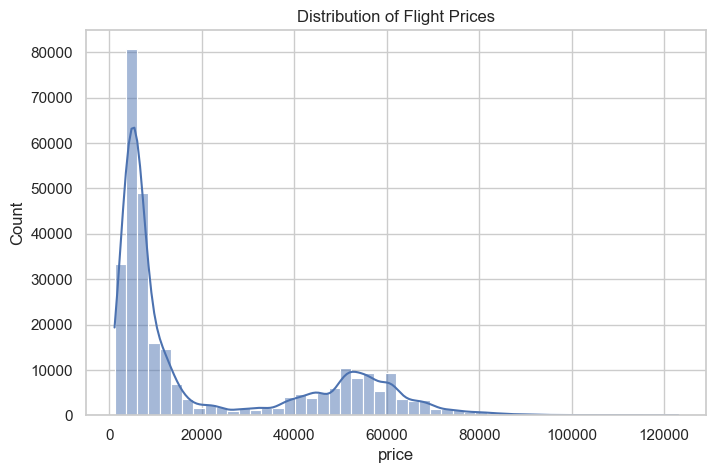

In [9]:
# --- Target Variable: Price Distribution ---
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of Flight Prices")
plt.show()

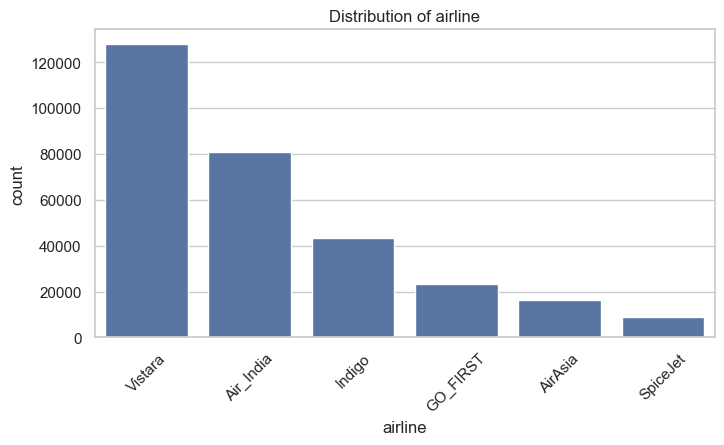

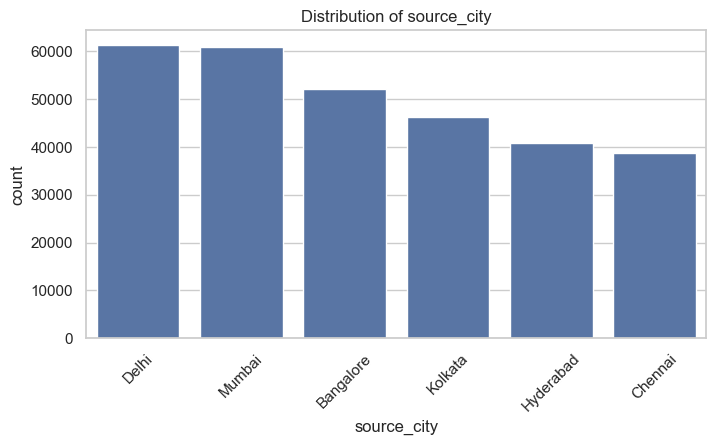

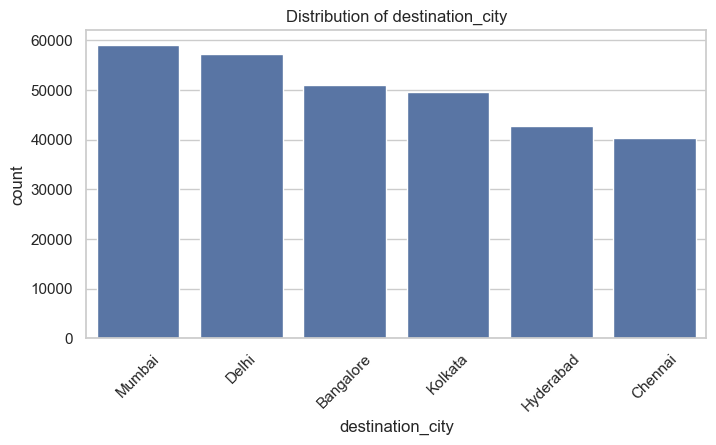

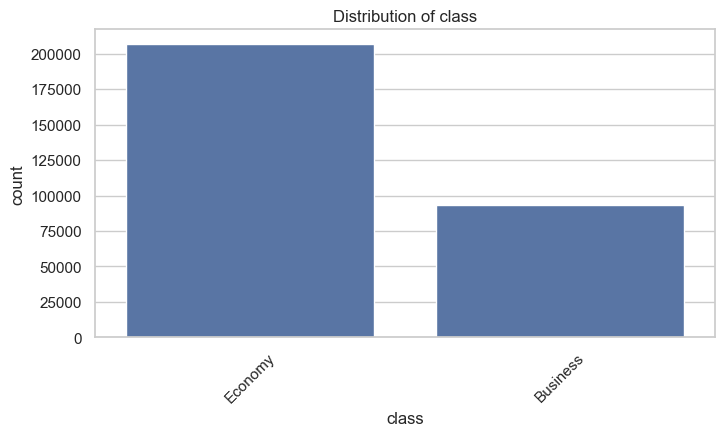

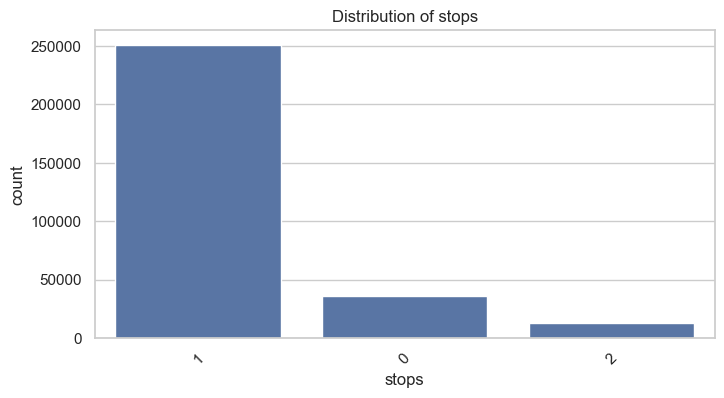

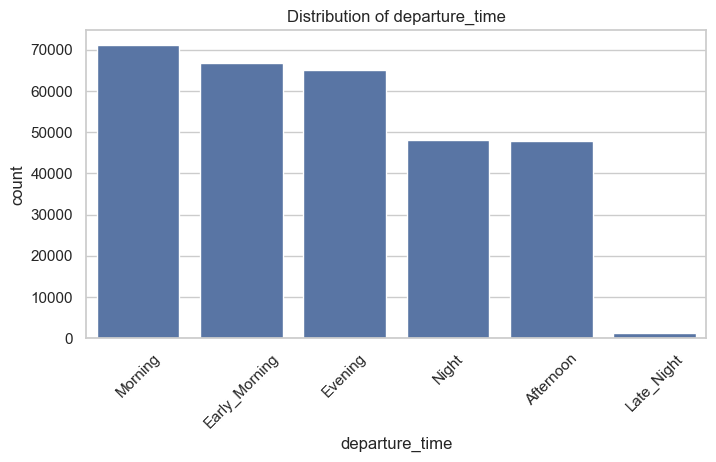

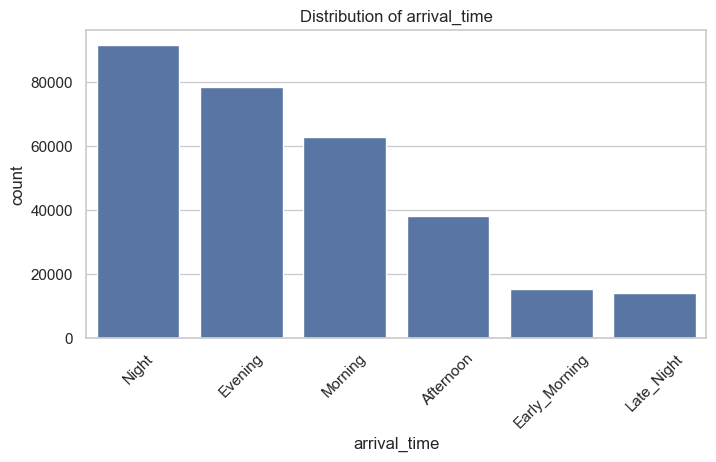

In [ ]:
# Count plots for categorical variables
categorical_cols = ['airline','source_city','destination_city',
                    'class','stops','departure_time','arrival_time']

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")
    plt.show()

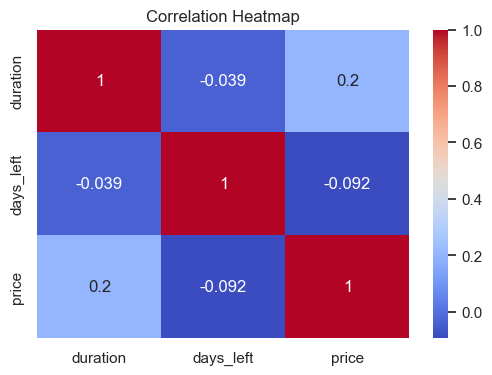

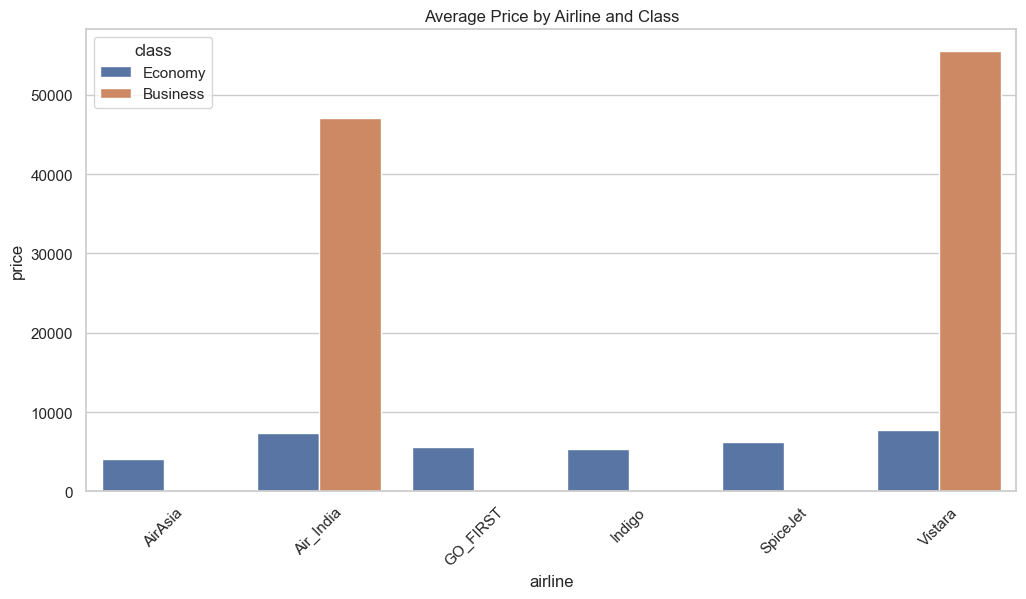

In [ ]:
# Correlation Heatmap (Numerical)
corr = df[['duration','days_left','price']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Grouped Insights
avg_price = df.groupby(['airline','class'])['price'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(x='airline', y='price', hue='class', data=avg_price)
plt.xticks(rotation=45)
plt.title("Average Price by Airline and Class")
plt.show()

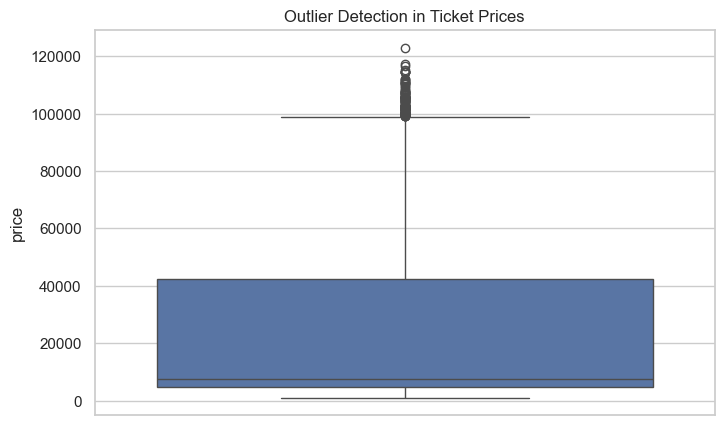

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(y='price', data=df)
plt.title("Outlier Detection in Ticket Prices")
plt.show()

## Feature Engineering

In [6]:
df['route'] = df['source_city'] + "_" + df['destination_city']

In [7]:
peak_times = ['Morning','Evening']
df['is_peak_time'] = df['departure_time'].apply(lambda x: 1 if x in peak_times else 0)


In [8]:
# Red-eye flights
df['is_red_eye'] = df['departure_time'].apply(lambda x: 1 if x=="Night" else 0)

# Price per hour (only for analysis, not for prediction since target leaks into features)
df['price_per_hour'] = df['price'] / df['duration']

# duration_category
df['duration_category'] = pd.cut(df['duration'],
                                 bins=[-1,2,4,24],
                                 labels=['short','medium','long'])

# Days left bucket
df['days_left_bucket'] = pd.cut(df['days_left'],
                                bins=[0,3,10,20,40,60],
                                labels=['0-3','4-10','11-20','21-40','41-60'])

In [9]:
# Encode categorical

cat_cols =['airline','source_city','destination_city','departure_time','arrival_time','class','route','duration_category','days_left_bucket']

num_cols = ['duration','stops','days_left','is_peak_time','is_red_eye']

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# ColumnTransformer
from sklearn.pipeline import make_pipeline
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop')

## Model Building and Evaluation

In [11]:
# Train/validation/test split (70/15/15)
train_val, test = train_test_split(df, test_size=0.15, random_state=42)
train, val = train_test_split(train_val, test_size=0.17647, random_state=42) # 0.17647 ~ 15/85 to make final 70/15/15

print("Train:", train.shape, "Val:", val.shape, "Test:", test.shape)

X_train = train.drop(columns=['price'])
y_train = train['price']
X_val = val.drop(columns=['price'])
y_val = val['price']
X_test = test.drop(columns=['price'])
y_test = test['price']

Train: (210107, 16) Val: (45023, 16) Test: (45023, 16)


In [12]:
# 1) Linear Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_val)
print("LR VAL RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_lr)), "MAE:", mean_absolute_error(y_val, y_pred_lr), "R²:", r2_score(y_val, y_pred_lr))

LR VAL RMSE: 6593.230438103226 MAE: 4475.851399098615 R²: 0.9157608450395467


In [13]:
# 2) XGBoost + RandomizedSearchCV

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=RND, n_jobs=-1, verbosity=0)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_reg)
])

param_dist = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__max_depth': [4,6,8],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.5, 0.7, 1.0],
    'regressor__reg_lambda': [0.1, 1, 10]
}

rs = RandomizedSearchCV(xgb_pipeline, param_distributions=param_dist, n_iter=20,
                        scoring='neg_root_mean_squared_error', cv=3, verbose=1, random_state=RND, n_jobs=1)

rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
best_xgb = rs.best_estimator_

# Evaluate on validation
y_pred_xgb = best_xgb.predict(X_val)
print("XGB VAL RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)), "MAE:", mean_absolute_error(y_val, y_pred_xgb), "R²:", r2_score(y_val, y_pred_xgb))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0.1, 'regressor__n_estimators': 300, 'regressor__max_depth': 8, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.7}
XGB VAL RMSE: 2861.0178258794544 MAE: 1556.73388671875 R²: 0.9841379523277283


TEST RMSE: 2894.52, MAE: 1568.76, R2: 0.984


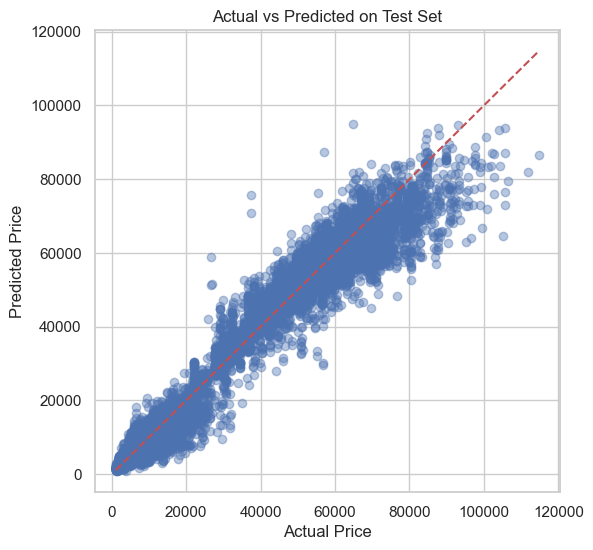

In [ ]:
# Final evaluation on test set

final_model = best_xgb  
y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"TEST RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, R2: {r2_test:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted on Test Set")
plt.show()


C:\Users\LENOVO PC\AppData\Local\Temp\ipykernel_25124\2537420347.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_preproc, feature_names=feature_names, show=True)


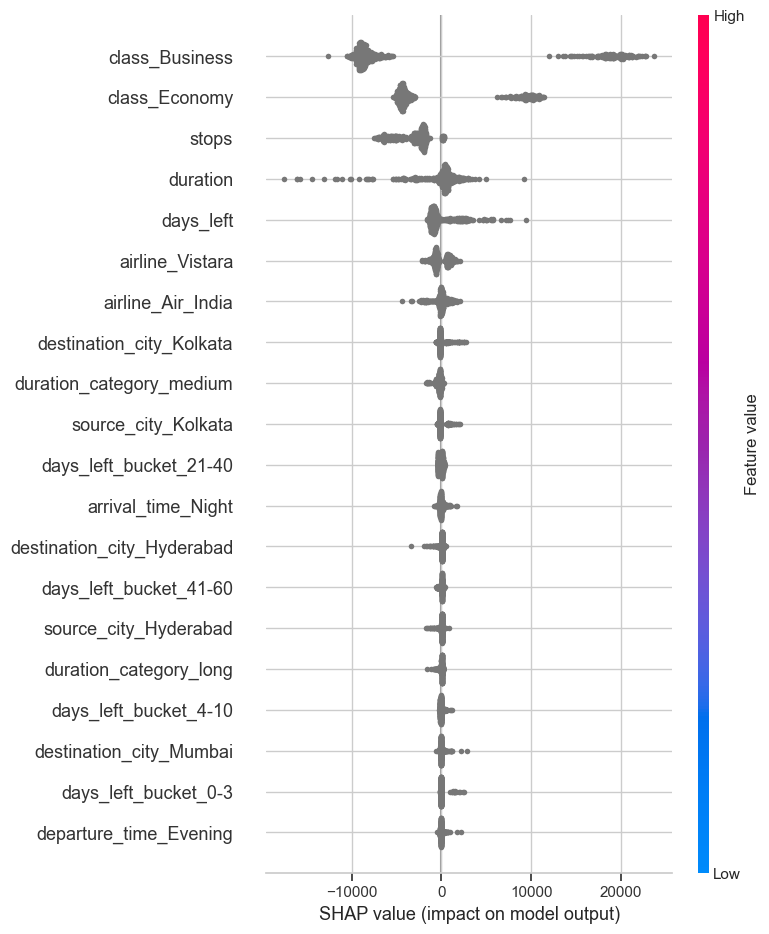

In [16]:
# Interpretation with SHAP (works best for tree models)
import shap

# Extract preprocessor feature names after OHE
# We need to fit preprocessor on full training data to get feature names
preprocessor.fit(pd.concat([X_train, X_val], axis=0))

# helper to retrieve feature names
def get_feature_names_from_preprocessor(preprocessor):
    num_features = num_cols
    cat_ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_features = cat_ohe.get_feature_names_out(cat_cols).tolist()
    return num_features + cat_features

feature_names = get_feature_names_from_preprocessor(preprocessor)
len(feature_names)  # sanity

# SHAP on XGBoost: get the underlying booster
# We need to extract the trained XGB model inside pipeline
xgb_model_in_pipeline = final_model.named_steps['regressor']
# Prepare preprocessed matrix for SHAP (use a sample)
X_sample = X_train.sample(500, random_state=42)
X_preproc = preprocessor.transform(X_sample)
explainer = shap.TreeExplainer(xgb_model_in_pipeline)
shap_values = explainer.shap_values(X_preproc)

# Summary plot
shap.summary_plot(shap_values, X_preproc, feature_names=feature_names, show=True)

## Deployment

In [ ]:
# Save the full pipeline (preprocessor + model) into one object
from sklearn.pipeline import Pipeline as SKPipeline
import joblib
from sklearn.preprocessing import OneHotEncoder, StandardScaler

full_pipeline = SKPipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model_in_pipeline)
])

joblib.dump(full_pipeline, "flight_price_pipeline.pkl")
print("Saved pipeline to flight_price_pipeline.pkl")


Saved pipeline to flight_price_pipeline.pkl
